In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import time
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

In [2]:
train = pd.read_csv('../data/X_train.csv')
test =  pd.read_csv('../data/X_test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')#This is a file with random numbers as predictions
                                                                #dans le futur fichier résultat ne pas mettre l'index

In [3]:
def check_trajectories_start_zero(df, traj_len=257):
    num_traj = len(df) // traj_len
    zero_traj = []

    for i in range(num_traj):
        start_idx = i * traj_len
        first_row = df.iloc[start_idx]

        # Controlla se tutti i valori della prima riga sono zero
        if (first_row == 0).all():
            zero_traj.append(i)

    return zero_traj

In [4]:
train_no_id = train.iloc[:, :-1]
traj_zero=check_trajectories_start_zero(train_no_id,257)

# convert trajectory indices into row indices
row_indices = [i * 257 for i in traj_zero]

print("Trajectories starting with zeros:", traj_zero)
print("Corresponding starting rows:", row_indices)

Trajectories starting with zeros: [1050, 4058]
Corresponding starting rows: [269850, 1042906]


In [5]:
def remove_zero_trajectories(df, zero_traj, traj_len=257):
    drop_indices = []

    for traj_id in zero_traj:
        start = traj_id * traj_len
        end = (traj_id + 1) * traj_len
        drop_indices.extend(range(start, end))

    df_cleaned = df.drop(drop_indices).reset_index(drop=True)
    return df_cleaned

In [6]:
train_cleaned = remove_zero_trajectories(train, traj_zero, 257)

CHECK ANOMALIES ON THE DATASE TRAIN_CLEANED

In [8]:
#Make sure you do not have the same initial positions in any two sets

df_t0 = train_cleaned[train_cleaned["t"] == 0].copy()
coords = ["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]
df_t0 = df_t0[~(df_t0[coords].eq(0).all(axis=1))]
duplicates = df_t0[df_t0.duplicated(subset=coords, keep=False)]
print(duplicates)#Never two times the same initial position

Empty DataFrame
Columns: [t, x_1, y_1, v_x_1, v_y_1, x_2, y_2, v_x_2, v_y_2, x_3, y_3, v_x_3, v_y_3, Id]
Index: []


In [9]:
def check_dataset_anomalies(df):
    print("Dataset anomalies check\n")

    # 1. Check for missing values (NaN)
    missing = df.isnull().sum().sum()
    if missing == 0:
        print("No missing values (NaN) found.")
    else:
        print(f"Found {missing} missing values (NaN).")
        print(df.isnull().sum()[df.isnull().sum() > 0])

    # 2. Check for infinite values
    inf_mask = df.isin([np.inf, -np.inf])
    inf_count = inf_mask.sum().sum()
    if inf_count == 0:
        print("No infinite values (+inf, -inf) found.")
    else:
        print(f"Found {inf_count} infinite values.")
        print(inf_mask.sum()[inf_mask.sum() > 0])

    # 3. Check for empty columns
    empty_cols = [col for col in df.columns if df[col].isnull().all()]
    if not empty_cols:
        print("No empty columns.")
    else:
        print(f"Found empty columns: {empty_cols}")


In [10]:
check_dataset_anomalies(train_cleaned)

Dataset anomalies check

No missing values (NaN) found.
No infinite values (+inf, -inf) found.
No empty columns.


CHECK THE STATISTICS OF THE DATASET

In [12]:
def dataset_summary(df):
    # Shape
    print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns\n")
    # Stats per column
    print("Basic statistics per column:")
    desc = df.describe().T
    print(desc[['min', 'mean', 'max']])

    # Standard deviation
    desc['std'] = df.std()
    print("\nStandard deviation:")
    print(desc['std'])

In [13]:
train_cleaned_no_id = train_cleaned.iloc[:, :-1]
dataset_summary(train_cleaned_no_id)

Shape: 1284486 rows, 13 columns

Basic statistics per column:
             min      mean        max
t       0.000000  4.146921  10.000000
x_1   -30.823004 -0.281400  16.340610
y_1   -17.857729 -0.109560  26.276226
v_x_1 -72.993333 -0.184200  23.503455
v_y_1 -23.109278 -0.016507  34.671679
x_2   -30.833398  0.007174  15.506957
y_2   -52.450808 -0.082044  35.679463
v_x_2 -25.895550  0.032490  72.718229
v_y_2 -48.289007 -0.083642  23.118346
x_3   -17.439994  0.274226  61.656402
y_3   -33.159997  0.191604  27.735539
v_x_3 -30.970540  0.151710  25.964992
v_y_3 -25.509384  0.100149  48.288738

Standard deviation:
t        3.209383
x_1      1.696094
y_1      1.167918
v_x_1    0.877679
v_y_1    0.806579
x_2      1.063197
y_2      1.038813
v_x_2    0.936416
v_y_2    0.975371
x_3      1.443690
y_3      1.683626
v_x_3    0.788051
v_y_3    0.871112
Name: std, dtype: float64


In [14]:
train=train_cleaned

#task 1.1

In [16]:
def split_trajectories(df, 
                       train_size=0.6, 
                       validation_size=0.2, 
                       test_size=0.2, 
                       traj_size=257, 
                       method="random", 
                       random_state=None):
    """
    Split un DataFrame en train, validation et test en respectant les trajectoires.

    Paramètres:
        df: DataFrame à splitter
        train_size, validation_size, test_size: fractions de trajectoires pour chaque split
        traj_size: nombre de lignes par trajectoire
        method: "random" (par défaut) ou d'autres méthodes à définir
        random_state: pour reproductibilité(seed)
    Retour:
        train_df, val_df, test_df
    """
    if random_state is not None:
        np.random.seed(random_state)

    n_traj = len(df) // traj_size
    if n_traj * traj_size != len(df):
        raise ValueError(f"Le DataFrame n'est pas divisible par {traj_size} (taille actuelle: {len(df)})")

    if train_size + validation_size + test_size > 1.0:
        raise ValueError("La somme de train_size, validation_size et test_size doit être <= 1.0")

    traj_indices = np.arange(n_traj)

    if method == "random":
        np.random.shuffle(traj_indices)
    else:
        raise NotImplementedError(f"Méthode {method} non implémentée pour l'instant")

    n_train = int(train_size * n_traj)
    n_val = int(validation_size * n_traj)
    n_test = int(test_size * n_traj)

    # Ajustement si n_train + n_val + n_test < n_traj
    n_remaining = n_traj - (n_train + n_val + n_test)
    n_train += n_remaining  # on ajoute le reste au train

    train_idx = traj_indices[:n_train]
    val_idx = traj_indices[n_train:n_train+n_val]
    test_idx = traj_indices[n_train+n_val:n_train+n_val+n_test]

    train_df = pd.concat([df.iloc[i*traj_size:(i+1)*traj_size] for i in train_idx])
    val_df = pd.concat([df.iloc[i*traj_size:(i+1)*traj_size] for i in val_idx])
    test_df = pd.concat([df.iloc[i*traj_size:(i+1)*traj_size] for i in test_idx])

    return train_df, val_df, test_df


In [17]:
train_after_split, validation_after_split, test_after_split = split_trajectories(train)

In [18]:
print(train_after_split.shape)
print(validation_after_split.shape)
print(test_after_split.shape)

(771000, 14)
(256743, 14)
(256743, 14)


In [19]:
# Récupérer les ensembles d'IDs pour chaque split
train_ids = set(train_after_split['Id'].unique())
val_ids = set(validation_after_split['Id'].unique())
test_ids = set(test_after_split['Id'].unique())

# Vérifier les intersections
print("Train ∩ Validation :", train_ids & val_ids)
print("Train ∩ Test :", train_ids & test_ids)
print("Validation ∩ Test :", val_ids & test_ids)

Train ∩ Validation : set()
Train ∩ Test : set()
Validation ∩ Test : set()


In [20]:
train_after_split.head(260)

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
588016,0.000000,1.000000,0.000000,0.000000,0.000000,-0.095275,0.308864,0.000000,0.000000,-0.904725,-0.308864,0.000000,0.000000,588273
588017,0.039062,0.999230,0.000127,-0.039410,0.006507,-0.095293,0.308257,-0.000931,-0.031060,-0.903937,-0.308384,0.040341,0.024553,588274
588018,0.078125,0.996919,0.000508,-0.078956,0.013010,-0.095349,0.306436,-0.001931,-0.062215,-0.901571,-0.306944,0.080887,0.049205,588275
588019,0.117188,0.993058,0.001143,-0.118777,0.019505,-0.095446,0.303394,-0.003073,-0.093564,-0.897613,-0.304537,0.121850,0.074059,588276
588020,0.156250,0.987634,0.002032,-0.159015,0.025987,-0.095592,0.299122,-0.004436,-0.125208,-0.892043,-0.301154,0.163452,0.099221,588277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588271,9.960940,-0.734831,1.719030,0.086085,-0.101775,0.228160,-0.607268,-0.129984,-0.185839,0.506671,-1.111763,0.043899,0.287613,588528
588272,10.000000,-0.731390,1.714870,0.090084,-0.111233,0.224185,-0.616453,-0.072470,-0.285251,0.507205,-1.098417,-0.017614,0.396483,588529
661004,0.000000,1.000000,0.000000,0.000000,0.000000,-0.238379,0.343062,0.000000,0.000000,-0.761621,-0.343062,0.000000,0.000000,661261
661005,0.039062,0.999322,0.000078,-0.034719,0.003994,-0.238556,0.342123,-0.009062,-0.048094,-0.760766,-0.342201,0.043781,0.044100,661262


In [21]:
validation_after_split.head(260)

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
246206,0.000000,1.000000,0.000000,0.000000,0.000000,-0.405809,0.174408,0.000000,0.000000,-0.594191,-0.174408,0.000000,0.000000,246206
246207,0.039062,0.999328,0.000014,-0.034437,0.000733,-0.407758,0.170054,-0.100805,-0.224742,-0.591570,-0.170069,0.135242,0.224008,246207
246208,0.078125,0.997308,0.000056,-0.068998,0.001399,-0.413857,0.156536,-0.215198,-0.474103,-0.583451,-0.156593,0.284196,0.472704,246208
246209,0.117188,0.993934,0.000122,-0.103807,0.001930,-0.425046,0.132153,-0.367365,-0.791849,-0.568888,-0.132275,0.471172,0.789920,246209
246210,0.156250,0.989193,0.000205,-0.138985,0.002263,-0.443956,0.092147,-0.635183,-1.318376,-0.545237,-0.092351,0.774168,1.316113,246210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246461,9.960940,0.769765,1.743202,-0.465381,-0.949634,0.818686,1.529876,0.474187,0.906660,-1.588451,-3.273078,-0.008805,0.042974,246461
246462,10.000000,0.758683,1.686112,0.078314,-2.167171,0.830089,1.585241,-0.070656,2.121836,-1.588773,-3.271353,-0.007658,0.045334,246462
328189,0.000000,1.000000,0.000000,0.000000,0.000000,-0.344981,0.286607,0.000000,0.000000,-0.655019,-0.286607,0.000000,0.000000,328446
328190,0.039062,0.999339,0.000038,-0.033864,0.001937,-0.345442,0.284940,-0.023720,-0.085499,-0.653897,-0.284977,0.057584,0.083562,328447


In [22]:
test_after_split.head(260)

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
158055,0.000000,1.000000,0.000000,0.000000,0.000000,-0.151527,0.738709,0.000000,0.000000,-0.848473,-0.738709,0.000000,0.000000,158055
158056,0.039062,0.999478,0.000149,-0.026731,0.007614,-0.151306,0.738230,0.011327,-0.024517,-0.848172,-0.738379,0.015405,0.016903,158056
158057,0.078125,0.997911,0.000595,-0.053529,0.015249,-0.150642,0.736793,0.022689,-0.049085,-0.847269,-0.737388,0.030840,0.033835,158057
158058,0.117188,0.995294,0.001341,-0.080461,0.022927,-0.149532,0.734394,0.034123,-0.073756,-0.845762,-0.735735,0.046338,0.050828,158058
158059,0.156250,0.991622,0.002387,-0.107597,0.030670,-0.147974,0.731029,0.045667,-0.098584,-0.843648,-0.733416,0.061930,0.067913,158059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158310,9.960940,-0.249637,0.885370,-0.565291,0.256056,0.263436,-0.847273,-0.368137,-0.590663,-0.013799,-0.038097,0.933428,0.334607,158310
158311,10.000000,-0.271432,0.894348,-0.550234,0.203980,0.248680,-0.869144,-0.386707,-0.529389,0.022752,-0.025204,0.936941,0.325409,158311
683106,0.000000,1.000000,0.000000,0.000000,0.000000,-0.481332,0.280946,0.000000,0.000000,-0.518668,-0.280946,0.000000,0.000000,683363
683107,0.039062,0.999356,0.000004,-0.033009,0.000222,-0.481162,0.278476,0.008676,-0.126829,-0.518194,-0.278480,0.024332,0.126607,683364


DATASET WITHOUT ALL THE COLLISIONS

DATASET THAT KEEP JUST THE FIRST ROW OF COLLISIONS

In [25]:
def get_time_vector(df, traj_len=257, tol=1e-8):

    num_traj = len(df) // traj_len
    feats = df.iloc[:, 1:-1].to_numpy()   # tutte le feature tranne tempo e Id

    for i in range(num_traj):
        start = i * traj_len
        end = start + traj_len

        block_feats = feats[start:end]
        zero_mask = np.all(np.abs(block_feats) < tol, axis=1)

        if not zero_mask.any():  # nessuna collisione
            return df.iloc[start:end, 0].to_numpy()  # solo la colonna tempo

    return None  # se tutte collidono

In [26]:
time_vec= get_time_vector(train, traj_len=257)

In [27]:
def keep_first_zero_time(df, time_vec, traj_len=257, tol=1e-8):

    cleaned = []
    num_traj = len(df) // traj_len

    for i in range(num_traj):
        start = i * traj_len
        end = (i + 1) * traj_len
        traj = df.iloc[start:end].copy()

        traj_features = traj.iloc[:, :-1]

        zero_mask = (np.abs(traj_features.values) < tol).all(axis=1)

        if zero_mask.any():
            first_zero_rel = int(np.argmax(zero_mask))   # posizione relativa
            # change the t=0 to t=time_vec[i]
            traj.iat[first_zero_rel, 0] = time_vec[first_zero_rel]
            traj = traj.iloc[:first_zero_rel + 1]

        cleaned.append(traj)

    cleaned_df = pd.concat(cleaned).reset_index(drop=True)
    return cleaned_df

In [28]:
train_with_first_collision=keep_first_zero_time(train_after_split,time_vec)

#task 1.2

In [55]:
def replicate_initial_position_by_block(df):
    print("ici")
    coords = ["x_1", "y_1",
              "x_2", "y_2",
              "x_3", "y_3"]
    
    copy = df.copy()
    data = copy[coords].values
    t_values = copy["t"].values
    
    # Détecter le début des blocs
    block_starts = np.where(t_values == 0)[0]
    block_starts = np.append(block_starts, len(df))  # ajouter fin du dernier bloc
    
    # Répliquer la position initiale pour chaque bloc
    for i in range(len(block_starts) - 1):
        start, end = block_starts[i], block_starts[i + 1]
        data[start:end] = data[start]  # réplication vectorisée
        
        # Dernière ligne : ne copier que si t == 10
        last_idx = end - 1
        if t_values[last_idx] != 10:
            data[last_idx] = copy.iloc[last_idx][coords].values
    
    copy[coords] = data
    return copy


In [57]:
train_entry=replicate_initial_position_by_block(train_after_split)
train_entry_with_first_collision=replicate_initial_position_by_block(train_with_first_collision)
validation_entry=replicate_initial_position_by_block(validation_after_split)
test_entry=replicate_initial_position_by_block(test_after_split)

ici
ici
ici
ici


In [141]:
train_entry.iloc[257*2:257*2+140:]#MODIFIER LES DONN

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
616543,0.000000,1.000000,0.000000,0.000000,0.000000,-0.148631,0.021207,0.000000,0.000000,-0.851369,-0.021207,0.000000,0.000000,616800
616544,0.039062,1.000000,0.000000,-0.040994,0.000415,-0.148631,0.021207,-0.049283,-0.005304,-0.851369,-0.021207,0.090278,0.004890,616801
616545,0.078125,1.000000,0.000000,-0.082036,0.000823,-0.148631,0.021207,-0.099829,-0.010670,-0.851369,-0.021207,0.181865,0.009846,616802
616546,0.117188,1.000000,0.000000,-0.123171,0.001219,-0.148631,0.021207,-0.153016,-0.016163,-0.851369,-0.021207,0.276187,0.014943,616803
616547,0.156250,1.000000,0.000000,-0.164447,0.001597,-0.148631,0.021207,-0.210486,-0.021863,-0.851369,-0.021207,0.374934,0.020266,616804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616678,5.273440,1.000000,0.000000,-1.313724,0.153342,-0.148631,0.021207,-0.475247,-0.028040,-0.851369,-0.021207,1.788971,-0.125302,616935
616679,5.312500,1.000000,0.000000,-1.504751,0.179047,-0.148631,0.021207,-0.661283,-0.036178,-0.851369,-0.021207,2.166035,-0.142869,616936
616680,5.351560,0.372095,-0.044259,-1.738061,0.208962,-0.103167,0.018916,-1.259337,-0.029452,-0.268927,0.025343,2.997398,-0.179510,616937
616681,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,616938


In [173]:
def rmse(y_true, y_pred):
    """
    Calcule le Root Mean Squared Error entre y_true et y_pred.

    Paramètres:
        y_true : array-like, valeurs réelles
        y_pred : array-like, valeurs prédites

    Retour:
        float, RMSE
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sqrt(np.mean((y_true - y_pred)**2))

In [167]:
# Récupérer les features et targets pour la validation
X_validation = validation_entry[["t","x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]].values
Y_validation = validation_after_split[["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]].values

rmse_scores = {}

for name, pipe in pipelines.items():
    # Prédictions
    Y_pred = pipe.predict(X_validation)
    
    # Calcul RMSE
    score = rmse(Y_validation, Y_pred)
    rmse_scores[name] = score
    print(f"{name}: RMSE = {score:.4f}")

# Trier les modèles par RMSE croissant
sorted_rmse = sorted(rmse_scores.items(), key=lambda x: x[1])
print("\nMeilleurs modèles (RMSE croissant) :")
for name, score in sorted_rmse:
    print(f"{name}: {score:.4f}")


Linear: RMSE = 1.2600
Ridge_alpha_0.01: RMSE = 1.2601
Ridge_alpha_0.1: RMSE = 1.2601
Ridge_alpha_1.0: RMSE = 1.2601
Lasso_alpha_0.01: RMSE = 1.2599
Lasso_alpha_0.1: RMSE = 1.2668
Lasso_alpha_1.0: RMSE = 1.3323

Meilleurs modèles (RMSE croissant) :
Lasso_alpha_0.01: 1.2599
Linear: 1.2600
Ridge_alpha_1.0: 1.2601
Ridge_alpha_0.1: 1.2601
Ridge_alpha_0.01: 1.2601
Lasso_alpha_0.1: 1.2668
Lasso_alpha_1.0: 1.3323


In [169]:
def plot_y_yhat(y_test,y_pred, plot_title = "plot"):
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    MAX = 500
    if len(y_test) > MAX:
        idx = np.random.choice(len(y_test),MAX, replace=False)
    else:
        idx = np.arange(len(y_test))
    plt.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_test[idx,i])
        x1 = np.max(y_test[idx,i])
        plt.subplot(3,2,i+1)
        plt.scatter(y_test[idx,i],y_pred[idx,i])
        plt.xlabel('True '+labels[i])
        plt.ylabel('Predicted '+labels[i])
        plt.plot([x0,x1],[x0,x1],color='red')
        plt.axis('square')
    plt.show()

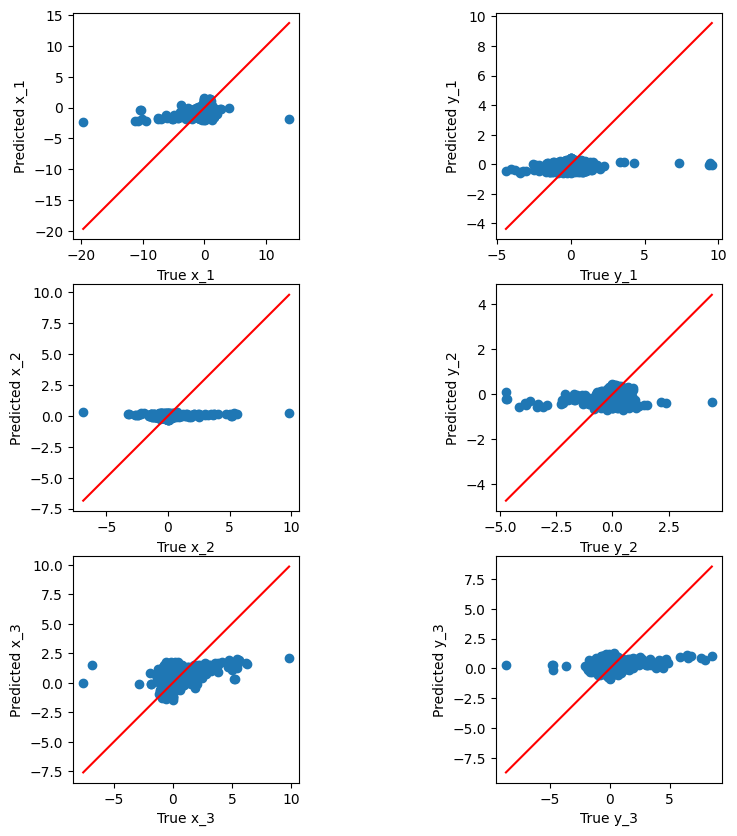

In [171]:
#Prends des points randoms si >500 points
plot_y_yhat(Y_validation,Y_validation_pred, plot_title = "plot")